In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import openai
import tiktoken
import time

openai.api_key = # insert key 
openai.api_base = "https://unocc-d-openai-eastus2-sentiment-opt-israel.openai.azure.com/" 
openai.api_type = 'azure'

# GPT-4
#openai.api_version = '2023-05-15' # this may change in the future
#deployment_name='unocc-d-aoai-eus2-gpt4-sentiment-opt-israel' #This will correspond to the custom name you chose for your deployment when you deployed a model. 

# GPT-3.5
openai.api_version = '2023-05-15' # this may change in the future
deployment_name='unocc-d-aoai-eus2-gpt-35-turbo-sentiment-opt-israel' #This will correspond to the custom name you chose for your deployment when you deployed a model. 


In [63]:
# Read a sample of 50 sentence extractions from Diplomatic Pulse Data
ds_data = pd.read_excel('50sample_extractions_moreRestrictive.xlsx')
columns_to_check = ['positive_israel', 'negative_israel', 'positive_opt', 'negative_opt','positive_hamas','negative_hamas']

# Drop rows where all specified columns contain empty strings
#ds_data = pd.read_csv('ExtractedSentences_new_20_sample.csv')
#ds_data = data1[~data1[columns_to_check].eq('[]').all(axis=1)]
#ds_data = ds_data.rename(columns={'Unnamed: 0': 'SId'})
# Store the original data in a new DataFrame
data = ds_data
seed=407

In [64]:
def num_tokens_from_messages(messages, model="gpt-4"):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = 0
    for message in messages:
        num_tokens += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":  # if there's a name, the role is omitted
                num_tokens += -1  # role is always required and always 1 token
    num_tokens += 2  # every reply is primed with <im_start>assistant
    return num_tokens

In [65]:
# Defining a function to send the prompt to the ChatGPT model
# More info : https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/chatgpt?pivots=programming-language-chat-completions
def send_message(messages):
    response = openai.ChatCompletion.create(
        engine=deployment_name,
        messages=messages,
        #seed=seed,
        temperature=0, # a higher value only for generative tasks
        top_p=0.1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    return response['choices'][0]['message']['content']

In [66]:
# Defining a function to print out the conversation in a readable format
def print_conversation(messages):
    for message in messages:
        print(f"[{message['role'].upper()}]")
        print(message['content'])
        print()

In [67]:
idx_extraction = ds_data.columns.get_loc('positive_israel')
def clean_extractions(df):
    """
    Function that cleans extractions in the input DataFrame by converting them to strings & removing brackets
    """
    for column in df.columns[idx_extraction:(idx_extraction+6)]:
        df.loc[:, column] = df.loc[:, column].astype(str)
        df.loc[:, column] = df.loc[:, column].str.replace("[", "",regex=False)
        df.loc[:, column] = df.loc[:, column].str.replace("]", "",regex=False)
        df.loc[:, column] = df.loc[:, column].str.replace("[]", "",regex=False)
    return df

ds_data= clean_extractions(ds_data)

In [69]:
def analyze_gpt(text, system_message):
    """
    Function that makes openai calls
    """
    if text=='':  # Check if the value is not an empty string
        return 0
    else:
        messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": f""" {text}"""}
        ]
    #print("system message: ", system_message)
    #print("num_tokens_from_messages: ", num_tokens_from_messages(messages))
    response = send_message(messages)

    return response
    #return num_tokens_from_messages(messages)


In [70]:
data.iloc[0,1]

"'During her trip, the Minister will reaffirm Canada’s support for Israel and its right to defend itself in accordance with international law'"

#InvalidRequestError: Unrecognized request argument supplied: seed

In [71]:
#score_pos_israel = "gpt4score_positive_israel"
#score_neg_israel = "gpt4score_negative_israel"
#score_pos_opt = "gpt4score_positive_opt"
#score_neg_opt = "gpt4score_negative_opt"
#score_pos_hamas = "gpt4score_positive_hamas"
#score_neg_hamas = "gpt4score_negative_hamas"

score_pos_israel = "gpt35score_positive_israel"
score_neg_israel = "gpt35score_negative_israel"
score_pos_opt = "gpt35score_positive_opt"
score_neg_opt = "gpt35score_negative_opt"
score_pos_hamas = "gpt35score_positive_hamas"
score_neg_hamas = "gpt35score_negative_hamas"

fields_list = [score_pos_israel, score_neg_israel, score_pos_opt, score_neg_opt, score_pos_hamas, score_neg_hamas]

# No bias

In [72]:
def create_message_no_bias(entity):
    sentiment_score=[]
    base_system_message =f""" You are helping with a sentiment analysis workflow, and
    returning a list containing a numerical sentiment score (call this list {sentiment_score}).
    Do not include preconceived notions about Israel, Palestine, Hamas, but only refer to the language used when assigning a sentiment score.
    The sentiment scoring should range from -1 (very negative sentiment), 0 neutral, 1 (very positive sentiment). The sentiment score increases or decreases in a continuous .1 interval.
    Please score the sentiments in the text towards {entity} using the previous sentiment scoring rules.
    Do not generate and return any text.
    Return only one overall numerical sentiment score for all the extracted sentences from the statement. 
    Return a list containing overall numerical sentiment score (call this list {sentiment_score})
    Here are a few non-exhaustive examples of sentiment scoring based on the rules provided.
    In this example A, the sentiment score towards Country A is 1.
    Example A Text:
    'your visit is another tangible example of our unequivocal support for Country A.', 'Thank you, for standing with Country A today, tomorrow, and always.', 'we’ve also been inspired by the bravery of Country A’s citizens', 'The people of Country A have long – and rightly – prided themselves on their self-reliance, on their ability to defend themselves, even when the odds are stacked against them.', 'You may be strong enough on your own to defend yourself – but as long as we exists, you will never, ever have to. We will always be there, by your side.', 'We welcome the government’s creation and the unity and resolve that it reflects across Country A’s society.', 'we will work with Congress to make sure that they’re met.', 'We has Country A’s back.', 'We’re pursuing intensive diplomacy throughout the region to prevent the conflict from spreading', 'Country A has the right – indeed, the obligation – to defend itself and to ensure that this never happens again.', 'That is what we will do, standing with Country A, working together with its people – and all those in this region who remain committed to the vision of a more peaceful, a more integrated, a more secure, a more prosperous Middle East.'
    In this example B, the sentiment score towards Country A is 0.833.
    Example B Text:
    'We stand with the people of Country A in the face of this terrorist assault.', 'Country A has the right to defend itself and its people.', 'We reiterate our ironclad support for Country A's exercise of its inherent right to defend itself in the face of this unjustified attack.'
    In this example C, the sentiment score towards Country A is 0.416.
    Example C Text:
    'Yesterday, I wrote to Country A's Foreign Minister Eli Cohen to express our deep condolences.', 'I visited Country A, and the occupied Country A's territory just one month ago.'
    In this example D, the sentiment score towards Country A is 0.
    Example D Text:
    'The Government unreservedly condemns the attacks on Country A carried out by the terrorist organisation Hamas.', 'In response to the attacks, the Government will instruct to conduct a review of aid to Country A to ensure that no funds go to actors that do not unconditionally condemn Hamas, that commit violence, threaten or encourage violence against the State of Country A or its population, or pursue an antisemitic agenda, nor to people associated with such actors.'
    In this example E, the sentiment score towards Country A is -0.417.
    Example E Text:
    'The ongoing harsh conditions under which the Country As live in veritable colonialism and Country A's sense of insecurity will contribute to a cycle of violence until those realities are definitively addressed.'
    In this example F, the sentiment score towards Country A is -0.917.
    Example F Text:
    'We hold Country A, the occupying power, fully responsible for the repercussions of the continuation of this sinful aggression,'
    In this example G, the sentiment score towards Country A is 0.75.
    Example G Text:
    'As Chair of the international donor group, we encourage the international community to continue its financial assistance to the Country A's people.', 'Humanitarian assistance to the people of Gaza should be a key priority.', 'Functioning Country A's institutions and adequate service delivery are critical to avoid further destabilization and maintaining the objective of the two-state solution.', 'I support any efforts at preventing a further deterioration of the situation.', 'To achieve peace, there is no alternative other than to restart a political process between Country A and Country A's.'
    In this example H, the sentiment score towards Country A is 0.5.
    Example H Text:
    'I was clear that continued development and humanitarian support to the Country A's people is essential.', 'I welcomed  the confirmation that humanitarian aid to Country A's will continue uninterrupted, for as long as needed.'
    In this example I, the sentiment score towards Country A is 0.
    Example I Text:
    'At the same time, as we're pursuing normalization, it's imperative that it not be a substitute for Country A and Country A's resolving the differences between them.  On the contrary, it needs to be something that actually advances that prospect and supports it.'
    In this example J, the sentiment score towards Country A is -0.25.
    Example J Text:
    ‘… underlined the need for the Country A's Authority to clearly distance itself from the Hamas terrorist organisation and condemn its attacks.'
    In this example K, the sentiment score towards Hamas is -0.083.
    Example K Text:   
    'We oppose and condemn acts harming civilians.'
    In this example L, the sentiment score towards Hamas is -0.583.
    Example L Text:   
    'The Government strongly condemns the terrorist attack in Country A today that caused loss of precious human lives and injured many more.'
    In this example M, the sentiment score towards Hamas is -0.75.
    Example M Text:   
    "Nothing justifies what we have seen Hamas engage in, and you've heard me, I think you and I have spoken before about our position in terms of seeking a just and enduring two-state solution which recognises the legitimate aspirations of both the Jewish and Country A's peoples.", 'Nothing justifies the violence, the hostage taking, the killing of civilians, the awful scenes we have seen Hamas engaging in.'
    In this example N, the sentiment score towards Hamas is -1.
    Example N Text:   
    'Hamas will understand that by attacking us, they have made a mistake of historic proportions.', 'The savage attacks that Hamas perpetrated against innocent Country A are mindboggling: Slaughtering families in their homes, massacring hundreds of young people at an outdoor festival, kidnapping scores of women, children and elderly, even Holocaust survivors.', 'Hamas terrorists bound, burned and executed children. They are savages.', 'Hamas is ISIS.', 'And just as the forces of civilization united to defeat ISIS, the forces of civilization must support Country A in defeating Hamas.'
    
    Please round the sentiment score upto 1 decimal point. Make sure that there are no score with more than 1 decimal point.
    """
    return base_system_message

In [73]:
def get_scores(df=ds_data):
    """
    Function that takes extractions DataFrame and an index for new statements as input and returns a DataFrame with sentiment scores and writes/appends it in a file
    Keeps the absolute values of scores for positive sentences, and -1 * absolute value of scores for the negative sentences
    """
    #df = clean_extractions(df)
    entity = []
    
    for i in range(0, len(fields_list)):

        column_index = idx_extraction + i
        if i<=1 :
            entity = "Israel"
        elif 1<i<=3 :
            entity = "Palestine"
        elif 3<i<=5:
            entity = "Hamas"
        
        print(entity)
        
        base_system_message =create_message_no_bias(entity)
        system_message = f"{base_system_message}".strip().replace('\n', '')
        col= fields_list[i]
        df.loc[:, col ] = df.iloc[:, column_index].apply(lambda x: analyze_gpt(x, system_message))
        

        # May have to pause openai calls if quota/token rate exceeds limit
        #runs_before_pause = 2   # This depends on size of the data
        #if i % runs_before_pause == 0:
        #   print("Pausing for 60 seconds...")
        #   time.sleep(60)  # Pause for 60 seconds
 
    for column in df.columns[(idx_extraction+6):]:
        df.loc[:, column] = df.loc[:, column].astype(str)
        df.loc[:, column] = df.loc[:, column].str.replace("[", "",regex=False)
        df.loc[:, column] = df.loc[:, column].str.replace("]", "",regex=False)
        df.loc[:, column] = df.loc[:, column].str.replace("''", "0",regex=False)
        df.loc[:, column] = pd.to_numeric(df.loc[:, column], errors='coerce')
    
    # Keep the absolute values for positive sentences, and -1 * absolute value for the negative sentences
    # Get index of the first score column, i.e. score for positive_israel
    col_idx_score = df.columns.get_loc(fields_list[0])
    positive_extractions = [col_idx_score, (col_idx_score+2), (col_idx_score+4)]
    negative_extractions = [(col_idx_score+1), (col_idx_score+3), (col_idx_score+5)]
    df.iloc[:, positive_extractions] = df.iloc[:, positive_extractions].abs()
    df.iloc[:, negative_extractions] = -df.iloc[:, negative_extractions].abs()

    # Write the DataFrame to an Excel file
    df.to_excel('no-bias-masked-examples-gpt35-50sample-SentimentScores-DiplomaticPulseIsraelPalestine.xlsx', index=False)

    return df

In [74]:
scores = get_scores(df=ds_data)

Israel
Israel
Palestine
Palestine
Hamas
Hamas


In [75]:
scores.head()

,Unnamed: 0,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,gpt35score_positive_israel,gpt35score_negative_israel,gpt35score_positive_opt,gpt35score_negative_opt,gpt35score_positive_hamas,gpt35score_negative_hamas
0,1,"'During her trip, the Minister will reaffirm C...",,,,,'discuss the impacts of Hamas’ terrorist attac...,0.8,-0.0,0.0,-0.0,0,-0.583
1,2,"'As a friend to both Israel and Palestine, wha...",,"'As a friend to both Israel and Palestine, wha...",,,'We oppose and condemn acts harming civilians.',0.5,-0.0,0.8,-0.0,0,-0.1
2,3,'the Foreign Minister expressed solidarity wit...,,,'Krišjānis Kariņš underlined the need for ...,,'following the violent attack by the Hamas ter...,0.8,-0.0,0.0,-0.25,0,-1.0
3,4,"'Yesterday, I wrote to Israeli Foreign Ministe...",,,,,'I again unreservedly condemn the attack by Ha...,0.416,-0.0,0.0,-0.0,0,-1.0
4,5,'your visit is another tangible example of Ame...,,'We know Hamas doesn’t represent the Palestini...,,,'Hamas has shown itself to be an enemy of civi...,1.0,-0.0,0.8,-0.0,0,-0.917


In [76]:
data = data.drop(columns=fields_list)

In [77]:
# Get consolidated scores for each entity-Israel, oPt, Hamas by differencing the positive and negative scores. Store these scores in the original DataFrame
col_idx_score = ds_data.columns.get_loc(fields_list[0])
ds_data[fields_list] = ds_data[fields_list].fillna(0)
#data['gpt4-Israel'] = ds_data.iloc[:,col_idx_score] + ds_data.iloc[:,(col_idx_score+1)]
#data['gpt4-Palestine'] = ds_data.iloc[:,(col_idx_score+2)] + ds_data.iloc[:,(col_idx_score+3)]
#data['gpt4-Hamas'] = ds_data.iloc[:,(col_idx_score+4)] + ds_data.iloc[:,(col_idx_score+5)]
data['gpt35-Israel'] = ds_data.iloc[:,col_idx_score] + ds_data.iloc[:,(col_idx_score+1)]
data['gpt35-Palestine'] = ds_data.iloc[:,(col_idx_score+2)] + ds_data.iloc[:,(col_idx_score+3)]
data['gpt35-Hamas'] = ds_data.iloc[:,(col_idx_score+4)] + ds_data.iloc[:,(col_idx_score+5)]
#data.head()


In [78]:
# Save consolidated scores in a dataframe
pred_scores = data.loc[:,['gpt35-Israel','gpt35-Palestine','gpt35-Hamas']]

# Read file with ground-truth scores and get the average scores for each entity                 
gtdata= pd.read_excel('AverageSentiment Scoring-RLU-DiplomaticPulse-Israel-oPt_issuingCountry.xlsx')
actual_avgscores = gtdata.iloc[:,12:15]

# Match index of ground truth scores with predicted scores because empty extractions were filtered out
acs = actual_avgscores.loc[data.index]
#acs.head()

In [79]:
mae_results = pd.DataFrame()

individual_maes = []
for i in range(3):
    abs_diff = abs(pred_scores.iloc[:, i] - acs.iloc[:, i])
    mae = np.mean(abs_diff)
    mae_results[i] = [mae]
    individual_maes.append(mae)

# Calculate overall MSE
overall_mae = np.mean(individual_maes)
mae_results['Overall'] = [overall_mae]

mae_results.index = ['MAE']
print(mae_results)

            0         1         2   Overall
MAE  0.395347  0.120327  0.248073  0.254582


In [80]:
mse_results = pd.DataFrame()

individual_mses = []
for i in range(3):
    squared_diff = (pred_scores.iloc[:, i] - acs.iloc[:, i]) ** 2
    mse = np.mean(squared_diff)
    mse_results[i] = [mse]
    individual_mses.append(mse)

# Calculate overall MSE
overall_mse = np.mean(individual_mses)
mse_results['Overall'] = [overall_mse]

mse_results.index = ['MSE']
print(mse_results)

            0         1         2   Overall
MSE  0.284152  0.048127  0.141994  0.158091


In [81]:
summary=pd.concat([mae_results,mse_results])
summary.columns = ['Israel', 'oPt','Hamas','Overall']
summary

,Israel,oPt,Hamas,Overall
MAE,0.395347,0.120327,0.248073,0.254582
MSE,0.284152,0.048127,0.141994,0.158091


In [82]:
# Get average ground truth scores in data
data['gt-score_israel'] = acs['Israel.3']
data['gt-score_opt'] = acs['Occupied Palestine Territory.3']
data['gt-score_hamas'] = acs['Hamas.3']
data.head()

,Unnamed: 0,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,gpt35-Israel,gpt35-Palestine,gpt35-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas
0,1,"'During her trip, the Minister will reaffirm C...",,,,,'discuss the impacts of Hamas’ terrorist attac...,0.800,0.00,-0.583,0.666667,0.250000,-0.750000
1,2,"'As a friend to both Israel and Palestine, wha...",,"'As a friend to both Israel and Palestine, wha...",,,'We oppose and condemn acts harming civilians.',0.500,0.80,-0.100,0.000000,0.250000,-0.083333
2,3,'the Foreign Minister expressed solidarity wit...,,,'Krišjānis Kariņš underlined the need for ...,,'following the violent attack by the Hamas ter...,0.800,-0.25,-1.000,0.583333,-0.250000,-0.750000
3,4,"'Yesterday, I wrote to Israeli Foreign Ministe...",,,,,'I again unreservedly condemn the attack by Ha...,0.416,0.00,-1.000,0.416667,0.250000,-0.833333
4,5,'your visit is another tangible example of Ame...,,'We know Hamas doesn’t represent the Palestini...,,,'Hamas has shown itself to be an enemy of civi...,1.000,0.80,-0.917,1.000000,0.083333,-0.916667


In [83]:
# Create 5 equal sized classes in the range -1 to 1 and classify both predicted and average ground truth scores
def to_sentiment(score):
  score = score
  if score <= -0.6:
    return "strong negative"
  elif score > -0.6 and score <= -0.2:
    return "weak negative"
  elif score > -0.2 and score < 0.2:
    return "neutral"
  elif score >=0.2 and score < 0.6:
    return "weak positive"
  elif score >= 0.6:
    return "strong positive"

#data['sentiment_israel'] = data['gpt4-Israel'].apply(lambda x: to_sentiment(x))
#data['sentiment_opt'] = data['gpt4-Palestine'].apply(lambda x: to_sentiment(x))
#data['sentiment_hamas'] = data['gpt4-Hamas'].apply(lambda x: to_sentiment(x))
data['sentiment_israel'] = data['gpt35-Israel'].apply(lambda x: to_sentiment(x))
data['sentiment_opt'] = data['gpt35-Palestine'].apply(lambda x: to_sentiment(x))
data['sentiment_hamas'] = data['gpt35-Hamas'].apply(lambda x: to_sentiment(x))
data[['gt_israel', 'gt_opt', 'gt_hamas']] = acs[['Israel.3','Occupied Palestine Territory.3','Hamas.3']].applymap(to_sentiment)
data.head()

,Unnamed: 0,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,gpt35-Israel,gpt35-Palestine,gpt35-Hamas,gt-score_israel,gt-score_opt,gt-score_hamas,sentiment_israel,sentiment_opt,sentiment_hamas,gt_israel,gt_opt,gt_hamas
0,1,"'During her trip, the Minister will reaffirm C...",,,,,'discuss the impacts of Hamas’ terrorist attac...,0.800,0.00,-0.583,0.666667,0.250000,-0.750000,strong positive,neutral,weak negative,strong positive,weak positive,strong negative
1,2,"'As a friend to both Israel and Palestine, wha...",,"'As a friend to both Israel and Palestine, wha...",,,'We oppose and condemn acts harming civilians.',0.500,0.80,-0.100,0.000000,0.250000,-0.083333,weak positive,strong positive,neutral,neutral,weak positive,neutral
2,3,'the Foreign Minister expressed solidarity wit...,,,'Krišjānis Kariņš underlined the need for ...,,'following the violent attack by the Hamas ter...,0.800,-0.25,-1.000,0.583333,-0.250000,-0.750000,strong positive,weak negative,strong negative,weak positive,weak negative,strong negative
3,4,"'Yesterday, I wrote to Israeli Foreign Ministe...",,,,,'I again unreservedly condemn the attack by Ha...,0.416,0.00,-1.000,0.416667,0.250000,-0.833333,weak positive,neutral,strong negative,weak positive,weak positive,strong negative
4,5,'your visit is another tangible example of Ame...,,'We know Hamas doesn’t represent the Palestini...,,,'Hamas has shown itself to be an enemy of civi...,1.000,0.80,-0.917,1.000000,0.083333,-0.916667,strong positive,strong positive,strong negative,strong positive,neutral,strong negative


In [84]:
class_names=['strong negative', 'weak negative', 'neutral','weak positive','strong positive']
titles = ['Israel', 'oPt', 'Hamas']
#Israel
x1=data.iloc[:,16] #ground-truth
y1=data.iloc[:,13] #predicted
cm1 = confusion_matrix(x1, y1, labels=class_names)
#oPt
x2=data.iloc[:,17]
y2=data.iloc[:,14]
cm2 = confusion_matrix(x2, y2, labels=class_names)
#Hamas
x3=data.iloc[:,18]
y3=data.iloc[:,15]
cm3 = confusion_matrix(x3, y3, labels=class_names)

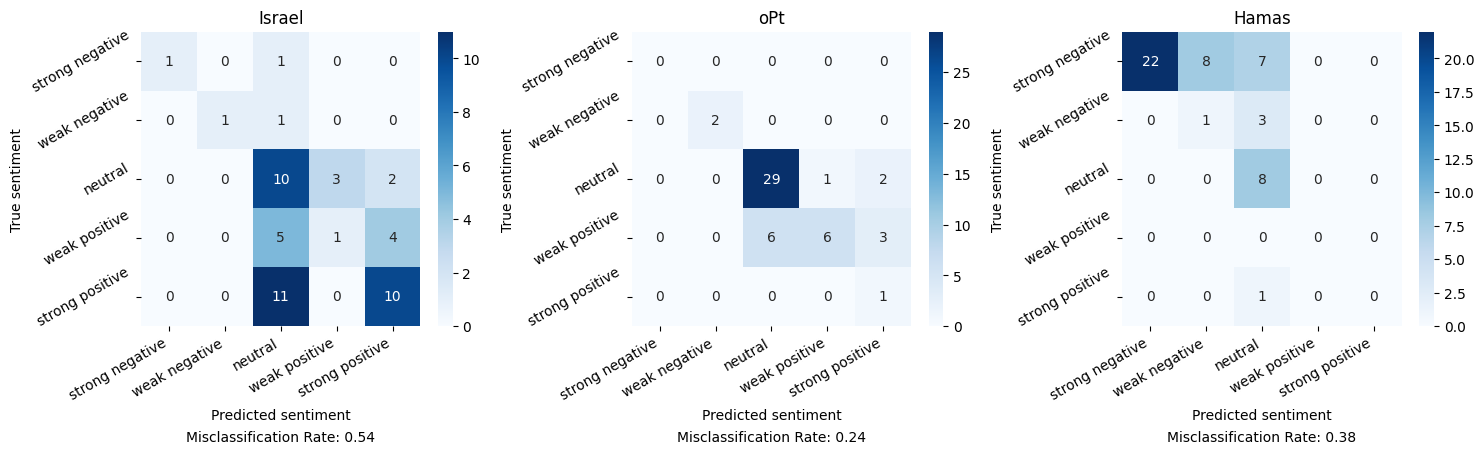

In [85]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Set the title for the subplot
    ax.set_title(titles[i])
    # Create a heatmap for each confusion matrix
    if i == 0:
        confusion_matrix = cm1
    elif i == 1:
        confusion_matrix = cm2
    else:
        confusion_matrix = cm3
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    
    # Set axis labels
    ax.set_xlabel('Predicted sentiment')
    ax.set_ylabel('True sentiment')
    
    # Calculate and display misclassification rate
    total = np.sum(confusion_matrix)
    misclassified = total - np.trace(confusion_matrix)
    misclassification_rate = misclassified / total
    ax.text(0.5, -0.39, f'Misclassification Rate: {misclassification_rate:.2f}', ha='center', transform=ax.transAxes)


# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
fig = plt.figure()

#plt.savefig('gpt35-equalboundary.png', transparent=False)
plt.close()

In [86]:
writer = pd.ExcelWriter('no-bias-masked-examples-gpt35-equalBC-DiplomaticPulseData.xlsx', engine='openpyxl')
data.to_excel(writer, sheet_name='Main', index=False)
ds_data.to_excel(writer, sheet_name='All_scores', index=False)
summary.to_excel(writer, sheet_name='Summary', index=True)
writer.book.save('no-bias-masked-examples-gpt35-equalBC-DiplomaticPulseData.xlsx')

# Bias

In [87]:
#score_pos_israel = "gpt4score_positive_israel"
#score_neg_israel = "gpt4score_negative_israel"
#score_pos_opt = "gpt4score_positive_opt"
#score_neg_opt = "gpt4score_negative_opt"
#score_pos_hamas = "gpt4score_positive_hamas"
#score_neg_hamas = "gpt4score_negative_hamas"

score_pos_israel = "bias_gpt35score_positive_israel"
score_neg_israel = "bias_gpt35score_negative_israel"
score_pos_opt = "bias_gpt35score_positive_opt"
score_neg_opt = "bias_gpt35score_negative_opt"
score_pos_hamas = "bias_gpt35score_positive_hamas"
score_neg_hamas = "bias_gpt35score_negative_hamas"

fields_list = [score_pos_israel, score_neg_israel, score_pos_opt, score_neg_opt, score_pos_hamas, score_neg_hamas]

In [88]:
def create_message_bias(entity):
    sentiment_score=[]
    base_system_message =f""" You are helping with a sentiment analysis workflow, and
    returning a list containing a numerical sentiment score (call this list {sentiment_score}).
    The sentiment scoring should range from -1 (very negative sentiment), 0 neutral, 1 (very positive sentiment). The sentiment score increases or decreases in a continuous .1 interval.
    Please score the sentiments in the text towards {entity} using the previous sentiment scoring rules.
    Do not generate and return any text.
    Return only one overall numerical sentiment score for all the extracted sentences from the statement. 
    Return a list containing overall numerical sentiment score (call this list {sentiment_score})
    Here are a few non-exhaustive examples of sentiment scoring based on the rules provided.
    In this example A, the sentiment score towards Country A is 1.
    Example A Text:
    'your visit is another tangible example of our unequivocal support for Country A.', 'Thank you, for standing with Country A today, tomorrow, and always.', 'we’ve also been inspired by the bravery of Country A’s citizens', 'The people of Country A have long – and rightly – prided themselves on their self-reliance, on their ability to defend themselves, even when the odds are stacked against them.', 'You may be strong enough on your own to defend yourself – but as long as we exists, you will never, ever have to. We will always be there, by your side.', 'We welcome the government’s creation and the unity and resolve that it reflects across Country A’s society.', 'we will work with Congress to make sure that they’re met.', 'We has Country A’s back.', 'We’re pursuing intensive diplomacy throughout the region to prevent the conflict from spreading', 'Country A has the right – indeed, the obligation – to defend itself and to ensure that this never happens again.', 'That is what we will do, standing with Country A, working together with its people – and all those in this region who remain committed to the vision of a more peaceful, a more integrated, a more secure, a more prosperous Middle East.'
    In this example B, the sentiment score towards Country A is 0.833.
    Example B Text:
    'We stand with the people of Country A in the face of this terrorist assault.', 'Country A has the right to defend itself and its people.', 'We reiterate our ironclad support for Country A's exercise of its inherent right to defend itself in the face of this unjustified attack.'
    In this example C, the sentiment score towards Country A is 0.416.
    Example C Text:
    'Yesterday, I wrote to Country A's Foreign Minister Eli Cohen to express our deep condolences.', 'I visited Country A, and the occupied Country A's territory just one month ago.'
    In this example D, the sentiment score towards Country A is 0.
    Example D Text:
    'The Government unreservedly condemns the attacks on Country A carried out by the terrorist organisation Hamas.', 'In response to the attacks, the Government will instruct to conduct a review of aid to Country A to ensure that no funds go to actors that do not unconditionally condemn Hamas, that commit violence, threaten or encourage violence against the State of Country A or its population, or pursue an antisemitic agenda, nor to people associated with such actors.'
    In this example E, the sentiment score towards Country A is -0.417.
    Example E Text:
    'The ongoing harsh conditions under which the Country As live in veritable colonialism and Country A's sense of insecurity will contribute to a cycle of violence until those realities are definitively addressed.'
    In this example F, the sentiment score towards Country A is -0.917.
    Example F Text:
    'We hold Country A, the occupying power, fully responsible for the repercussions of the continuation of this sinful aggression,'
    In this example G, the sentiment score towards Country A is 0.75.
    Example G Text:
    'As Chair of the international donor group, we encourage the international community to continue its financial assistance to the Country A's people.', 'Humanitarian assistance to the people of Gaza should be a key priority.', 'Functioning Country A's institutions and adequate service delivery are critical to avoid further destabilization and maintaining the objective of the two-state solution.', 'I support any efforts at preventing a further deterioration of the situation.', 'To achieve peace, there is no alternative other than to restart a political process between Country A and Country A's.'
    In this example H, the sentiment score towards Country A is 0.5.
    Example H Text:
    'I was clear that continued development and humanitarian support to the Country A's people is essential.', 'I welcomed  the confirmation that humanitarian aid to Country A's will continue uninterrupted, for as long as needed.'
    In this example I, the sentiment score towards Country A is 0.
    Example I Text:
    'At the same time, as we're pursuing normalization, it's imperative that it not be a substitute for Country A and Country A's resolving the differences between them.  On the contrary, it needs to be something that actually advances that prospect and supports it.'
    In this example J, the sentiment score towards Country A is -0.25.
    Example J Text:
    ‘… underlined the need for the Country A's Authority to clearly distance itself from the Hamas terrorist organisation and condemn its attacks.'
    In this example K, the sentiment score towards Hamas is -0.083.
    Example K Text:   
    'We oppose and condemn acts harming civilians.'
    In this example L, the sentiment score towards Hamas is -0.583.
    Example L Text:   
    'The Government strongly condemns the terrorist attack in Country A today that caused loss of precious human lives and injured many more.'
    In this example M, the sentiment score towards Hamas is -0.75.
    Example M Text:   
    "Nothing justifies what we have seen Hamas engage in, and you've heard me, I think you and I have spoken before about our position in terms of seeking a just and enduring two-state solution which recognises the legitimate aspirations of both the Jewish and Country A's peoples.", 'Nothing justifies the violence, the hostage taking, the killing of civilians, the awful scenes we have seen Hamas engaging in.'
    In this example N, the sentiment score towards Hamas is -1.
    Example N Text:   
    'Hamas will understand that by attacking us, they have made a mistake of historic proportions.', 'The savage attacks that Hamas perpetrated against innocent Country A are mindboggling: Slaughtering families in their homes, massacring hundreds of young people at an outdoor festival, kidnapping scores of women, children and elderly, even Holocaust survivors.', 'Hamas terrorists bound, burned and executed children. They are savages.', 'Hamas is ISIS.', 'And just as the forces of civilization united to defeat ISIS, the forces of civilization must support Country A in defeating Hamas.'
    
    Please round the sentiment score upto 1 decimal point. Make sure that there are no score with more than 1 decimal point.
    """
    return base_system_message

In [89]:
def get_scores(df=ds_data):
    """
    Function that takes extractions DataFrame and an index for new statements as input and returns a DataFrame with sentiment scores and writes/appends it in a file
    Keeps the absolute values of scores for positive sentences, and -1 * absolute value of scores for the negative sentences
    """
    #df = clean_extractions(df)
    entity = []
    
    for i in range(0, len(fields_list)):

        column_index = idx_extraction + i
        if i<=1 :
            entity = "Israel"
        elif 1<i<=3 :
            entity = "Palestine"
        elif 3<i<=5:
            entity = "Hamas"
        
        print(entity)
        
        base_system_message =create_message_bias(entity)
        system_message = f"{base_system_message}".strip().replace('\n', '')
        col= fields_list[i]
        print(col)
        df.loc[:, col ] = df.iloc[:, column_index].apply(lambda x: analyze_gpt(x, system_message))
        

        # May have to pause openai calls if quota/token rate exceeds limit
        #runs_before_pause = 2   # This depends on size of the data
        #if i % runs_before_pause == 0:
        #   print("Pausing for 60 seconds...")
        #   time.sleep(60)  # Pause for 60 seconds
 
    for column in df.columns[(idx_extraction+6):]:
        df.loc[:, column] = df.loc[:, column].astype(str)
        df.loc[:, column] = df.loc[:, column].str.replace("[", "",regex=False)
        df.loc[:, column] = df.loc[:, column].str.replace("]", "",regex=False)
        df.loc[:, column] = df.loc[:, column].str.replace("''", "0",regex=False)
        df.loc[:, column] = pd.to_numeric(df.loc[:, column], errors='coerce')
    
    # Keep the absolute values for positive sentences, and -1 * absolute value for the negative sentences
    # Get index of the first score column, i.e. score for positive_israel
    col_idx_score = df.columns.get_loc(fields_list[0])
    positive_extractions = [col_idx_score, (col_idx_score+2), (col_idx_score+4)]
    negative_extractions = [(col_idx_score+1), (col_idx_score+3), (col_idx_score+5)]
    df.iloc[:, positive_extractions] = df.iloc[:, positive_extractions].abs()
    df.iloc[:, negative_extractions] = -df.iloc[:, negative_extractions].abs()

    # Write the DataFrame to an Excel file
    df.to_excel('bias-masked-examples-gpt35-50sample-SentimentScores-DiplomaticPulseIsraelPalestine.xlsx', index=False)

    return df
scores = get_scores(df=ds_data)

Israel
bias_gpt35score_positive_israel
Israel
bias_gpt35score_negative_israel
Palestine
bias_gpt35score_positive_opt
Palestine
bias_gpt35score_negative_opt
Hamas
bias_gpt35score_positive_hamas
Hamas
bias_gpt35score_negative_hamas


In [90]:
scores.head()

,Unnamed: 0,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,gpt35score_positive_israel,gpt35score_negative_israel,gpt35score_positive_opt,gpt35score_negative_opt,gpt35score_positive_hamas,gpt35score_negative_hamas,bias_gpt35score_positive_israel,bias_gpt35score_negative_israel,bias_gpt35score_positive_opt,bias_gpt35score_negative_opt,bias_gpt35score_positive_hamas,bias_gpt35score_negative_hamas
0,1,"'During her trip, the Minister will reaffirm C...",,,,,'discuss the impacts of Hamas’ terrorist attac...,0.8,-0.0,0.0,-0.0,0,-0.583,0.8,-0.0,0.0,-0.0,0,-0.583
1,2,"'As a friend to both Israel and Palestine, wha...",,"'As a friend to both Israel and Palestine, wha...",,,'We oppose and condemn acts harming civilians.',0.5,-0.0,0.8,-0.0,0,-0.1,0.5,-0.0,0.9,-0.0,0,-0.1
2,3,'the Foreign Minister expressed solidarity wit...,,,'Krišjānis Kariņš underlined the need for ...,,'following the violent attack by the Hamas ter...,0.8,-0.0,0.0,-0.25,0,-1.0,0.8,-0.0,0.0,-0.0,0,-1.0
3,4,"'Yesterday, I wrote to Israeli Foreign Ministe...",,,,,'I again unreservedly condemn the attack by Ha...,0.416,-0.0,0.0,-0.0,0,-1.0,0.083,-0.0,0.0,-0.0,0,-1.0
4,5,'your visit is another tangible example of Ame...,,'We know Hamas doesn’t represent the Palestini...,,,'Hamas has shown itself to be an enemy of civi...,1.0,-0.0,0.8,-0.0,0,-0.917,1.0,-0.0,0.9,-0.0,0,-0.792


In [92]:
# Get consolidated scores for each entity-Israel, oPt, Hamas by differencing the positive and negative scores. Store these scores in the original DataFrame
col_idx_score = ds_data.columns.get_loc(fields_list[0])
ds_data[fields_list] = ds_data[fields_list].fillna(0)
#data['gpt4-Israel'] = ds_data.iloc[:,col_idx_score] + ds_data.iloc[:,(col_idx_score+1)]
#data['gpt4-Palestine'] = ds_data.iloc[:,(col_idx_score+2)] + ds_data.iloc[:,(col_idx_score+3)]
#data['gpt4-Hamas'] = ds_data.iloc[:,(col_idx_score+4)] + ds_data.iloc[:,(col_idx_score+5)]
data['bias_gpt35-Israel'] = ds_data.iloc[:,col_idx_score] + ds_data.iloc[:,(col_idx_score+1)]
data['bias_gpt35-Palestine'] = ds_data.iloc[:,(col_idx_score+2)] + ds_data.iloc[:,(col_idx_score+3)]
data['bias_gpt35-Hamas'] = ds_data.iloc[:,(col_idx_score+4)] + ds_data.iloc[:,(col_idx_score+5)]
#data.head()

In [93]:
# Save consolidated scores in a dataframe
pred_scores = data.loc[:,['bias_gpt35-Israel','bias_gpt35-Palestine','bias_gpt35-Hamas']]

# Read file with ground-truth scores and get the average scores for each entity                 
gtdata= pd.read_excel('AverageSentiment Scoring-RLU-DiplomaticPulse-Israel-oPt_issuingCountry.xlsx')
actual_avgscores = gtdata.iloc[:,12:15]

# Match index of ground truth scores with predicted scores because empty extractions were filtered out
acs = actual_avgscores.loc[data.index]
#acs.head()

In [94]:
mae_results = pd.DataFrame()

individual_maes = []
for i in range(3):
    abs_diff = abs(pred_scores.iloc[:, i] - acs.iloc[:, i])
    mae = np.mean(abs_diff)
    mae_results[i] = [mae]
    individual_maes.append(mae)

# Calculate overall MSE
overall_mae = np.mean(individual_maes)
mae_results['Overall'] = [overall_mae]

mae_results.index = ['MAE']
print(mae_results)
mse_results = pd.DataFrame()

individual_mses = []
for i in range(3):
    squared_diff = (pred_scores.iloc[:, i] - acs.iloc[:, i]) ** 2
    mse = np.mean(squared_diff)
    mse_results[i] = [mse]
    individual_mses.append(mse)

# Calculate overall MSE
overall_mse = np.mean(individual_mses)
mse_results['Overall'] = [overall_mse]

mse_results.index = ['MSE']
print(mse_results)
summary=pd.concat([mae_results,mse_results])
summary.columns = ['Israel', 'oPt','Hamas','Overall']
summary

            0         1         2   Overall
MAE  0.247007  0.121993  0.206893  0.191964
           0        1         2   Overall
MSE  0.12388  0.05131  0.092391  0.089194


,Israel,oPt,Hamas,Overall
MAE,0.247007,0.121993,0.206893,0.191964
MSE,0.123880,0.051310,0.092391,0.089194


In [98]:
# Get average ground truth scores in data
data['gt-score_israel'] = acs['Israel.3']
data['gt-score_opt'] = acs['Occupied Palestine Territory.3']
data['gt-score_hamas'] = acs['Hamas.3']
data.head()
# Create 5 equal sized classes in the range -1 to 1 and classify both predicted and average ground truth scores
def to_sentiment(score):
  score = score
  if score <= -0.6:
    return "strong negative"
  elif score > -0.6 and score <= -0.2:
    return "weak negative"
  elif score > -0.2 and score < 0.2:
    return "neutral"
  elif score >=0.2 and score < 0.6:
    return "weak positive"
  elif score >= 0.6:
    return "strong positive"

#data['sentiment_israel'] = data['gpt4-Israel'].apply(lambda x: to_sentiment(x))
#data['sentiment_opt'] = data['gpt4-Palestine'].apply(lambda x: to_sentiment(x))
#data['sentiment_hamas'] = data['gpt4-Hamas'].apply(lambda x: to_sentiment(x))
data['sentiment_israel'] = data['bias_gpt35-Israel'].apply(lambda x: to_sentiment(x))
data['sentiment_opt'] = data['bias_gpt35-Palestine'].apply(lambda x: to_sentiment(x))
data['sentiment_hamas'] = data['bias_gpt35-Hamas'].apply(lambda x: to_sentiment(x))
data[['gt_israel', 'gt_opt', 'gt_hamas']] = acs[['Israel.3','Occupied Palestine Territory.3','Hamas.3']].applymap(to_sentiment)
data.head()

,Unnamed: 0,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,gpt35-Israel,gpt35-Palestine,gpt35-Hamas,...,gt-score_hamas,sentiment_israel,sentiment_opt,sentiment_hamas,gt_israel,gt_opt,gt_hamas,bias_gpt35-Israel,bias_gpt35-Palestine,bias_gpt35-Hamas
0,1,"'During her trip, the Minister will reaffirm C...",,,,,'discuss the impacts of Hamas’ terrorist attac...,0.800,0.00,-0.583,...,-0.750000,strong positive,neutral,weak negative,strong positive,weak positive,strong negative,0.800,0.0,-0.583
1,2,"'As a friend to both Israel and Palestine, wha...",,"'As a friend to both Israel and Palestine, wha...",,,'We oppose and condemn acts harming civilians.',0.500,0.80,-0.100,...,-0.083333,weak positive,strong positive,neutral,neutral,weak positive,neutral,0.500,0.9,-0.100
2,3,'the Foreign Minister expressed solidarity wit...,,,'Krišjānis Kariņš underlined the need for ...,,'following the violent attack by the Hamas ter...,0.800,-0.25,-1.000,...,-0.750000,strong positive,neutral,strong negative,weak positive,weak negative,strong negative,0.800,0.0,-1.000
3,4,"'Yesterday, I wrote to Israeli Foreign Ministe...",,,,,'I again unreservedly condemn the attack by Ha...,0.416,0.00,-1.000,...,-0.833333,neutral,neutral,strong negative,weak positive,weak positive,strong negative,0.083,0.0,-1.000
4,5,'your visit is another tangible example of Ame...,,'We know Hamas doesn’t represent the Palestini...,,,'Hamas has shown itself to be an enemy of civi...,1.000,0.80,-0.917,...,-0.916667,strong positive,strong positive,strong negative,strong positive,neutral,strong negative,1.000,0.9,-0.792


In [99]:
data.head()

,Unnamed: 0,positive_israel,negative_israel,positive_opt,negative_opt,positive_hamas,negative_hamas,gpt35-Israel,gpt35-Palestine,gpt35-Hamas,...,gt-score_hamas,sentiment_israel,sentiment_opt,sentiment_hamas,gt_israel,gt_opt,gt_hamas,bias_gpt35-Israel,bias_gpt35-Palestine,bias_gpt35-Hamas
0,1,"'During her trip, the Minister will reaffirm C...",,,,,'discuss the impacts of Hamas’ terrorist attac...,0.800,0.00,-0.583,...,-0.750000,strong positive,neutral,weak negative,strong positive,weak positive,strong negative,0.800,0.0,-0.583
1,2,"'As a friend to both Israel and Palestine, wha...",,"'As a friend to both Israel and Palestine, wha...",,,'We oppose and condemn acts harming civilians.',0.500,0.80,-0.100,...,-0.083333,weak positive,strong positive,neutral,neutral,weak positive,neutral,0.500,0.9,-0.100
2,3,'the Foreign Minister expressed solidarity wit...,,,'Krišjānis Kariņš underlined the need for ...,,'following the violent attack by the Hamas ter...,0.800,-0.25,-1.000,...,-0.750000,strong positive,neutral,strong negative,weak positive,weak negative,strong negative,0.800,0.0,-1.000
3,4,"'Yesterday, I wrote to Israeli Foreign Ministe...",,,,,'I again unreservedly condemn the attack by Ha...,0.416,0.00,-1.000,...,-0.833333,neutral,neutral,strong negative,weak positive,weak positive,strong negative,0.083,0.0,-1.000
4,5,'your visit is another tangible example of Ame...,,'We know Hamas doesn’t represent the Palestini...,,,'Hamas has shown itself to be an enemy of civi...,1.000,0.80,-0.917,...,-0.916667,strong positive,strong positive,strong negative,strong positive,neutral,strong negative,1.000,0.9,-0.792


In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
class_names=['strong negative', 'weak negative', 'neutral','weak positive','strong positive']
titles = ['Israel', 'oPt', 'Hamas']
#Israel
x_1=data.iloc[:,16] #ground-truth
y_1=data.iloc[:,13] #predicted
cm_1 = confusion_matrix(x_1, y_1, labels=class_names)
#oPt
x_2=data.iloc[:,17]
y_2=data.iloc[:,14]
cm_2 = confusion_matrix(x_2, y_2, labels=class_names)
#Hamas
x_3=data.iloc[:,18]
y_3=data.iloc[:,15]
cm_3 = confusion_matrix(x_3, y_3, labels=class_names)

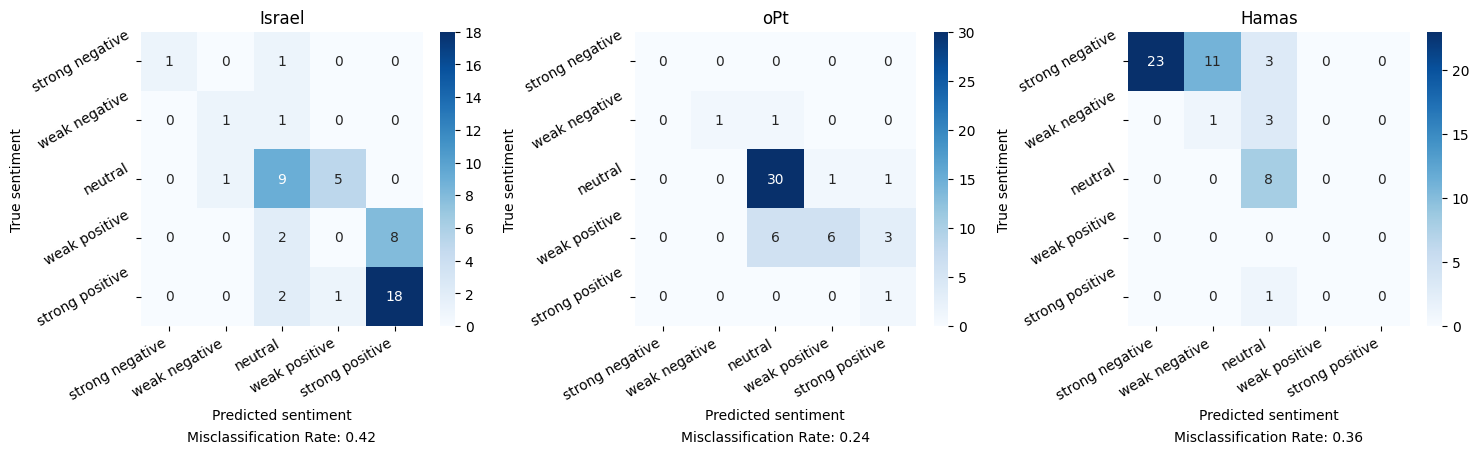

In [119]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Set the title for the subplot
    ax.set_title(titles[i])
    # Create a heatmap for each confusion matrix
    if i == 0:
        confusion_matrix = cm_1
    elif i == 1:
        confusion_matrix = cm_2
    else:
        confusion_matrix = cm_3
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=30, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    
    # Set axis labels
    ax.set_xlabel('Predicted sentiment')
    ax.set_ylabel('True sentiment')
    
    # Calculate and display misclassification rate
    total = np.sum(confusion_matrix)
    misclassified = total - np.trace(confusion_matrix)
    misclassification_rate = misclassified / total
    ax.text(0.5, -0.39, f'Misclassification Rate: {misclassification_rate:.2f}', ha='center', transform=ax.transAxes)


# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
fig = plt.figure()

#plt.savefig('gpt35-equalboundary.png', transparent=False)
plt.close()

In [120]:
writer = pd.ExcelWriter('bias-masked-examples-gpt35-equalBC-DiplomaticPulseData.xlsx', engine='openpyxl')
data.to_excel(writer, sheet_name='Main', index=False)
ds_data.to_excel(writer, sheet_name='All_scores', index=False)
summary.to_excel(writer, sheet_name='Summary', index=True)
writer.book.save('bias-masked-examples-gpt35-equalBC-DiplomaticPulseData.xlsx')